# Markovian Model for steady-state throughput CUBIC and Hybla
Based on the paper by Bao Wong and Leung.
First we try to replicate their model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True



First we try to just compute different stationnary distributions for CUBIC for different parameters. Then we shall do the same with Hybla. Then we can do the concatenation.

In [2]:
class CCA_CUBIC_MarkovChain:
    def __init__(self, N=400, C = 1000, trans_err = 0.01, alpha = 1, beta = 0.5, RTT = 0.025, bit_err = 0.05):
        self.N = N # number of states
        self.W = C*RTT # in Mbyte, W = C*RTT where C is the maximum bandwidth
        self.RTT = RTT # in ms 
        self.trans_err = trans_err # a.k.a. lambda
        self.bit_err = bit_err # probability that a packet drops 
        self.alpha = alpha # window growth rate
        self.beta = beta # window reduction ratio
        self.a = (np.linspace(1,N,N)-0.5)*self.W/N # Discretisation of the window-size
        self.pi = np.ones(N)/N # Stationnary Distribution
        self.P = None # Transition Probability Matrix
        self.S = None
        self.tau = None 
        self.x = 0 # Steady State average throughput

    def D(self,x,y): # growth time
        return np.cbrt((y-x)/self.alpha)+np.cbrt((1-self.beta)*x/self.alpha)
    
    def avg_w(self,t,x):
        return 1/(t)*(x*t+1/4*(t-np.cbrt((1-self.beta)*x/self.alpha))) #not finished

    def transition_proba_CUBIC(self,i,j): # Probability to transition from i to j
        l = self.trans_err
        if j < self.beta*(i-0.5):
            return 0
        if j == self.N:
            sum = 0
            for jp in np.linspace(1,self.N-1,self.N-1):
                if jp >= self.beta*(i-0.5):
                    sum += self.transition_proba_CUBIC(i,jp)
            return 1-sum
        return np.exp(-l* np.maximum(self.D(self.a[i-1],(j-1)*self.W/self.N),0)) - np.exp(-l* self.D(self.a[i-1],j*self.W/self.N))
    
    def compute_stationnary_distribution(self):
        # 1. Compute the transition probability Matrix P
        self.P = np.zeros([self.N,self.N])
        for i in range(self.N):
            for j in range(self.N):
                if j == self.N:
                    self.P[i,j] = np.sum(self.P[i,:-1])
                    continue
                self.P[i,j] = self.transition_proba_CUBIC(i+1,j+1)

        # 2. Solve the system of equation (16)&(17) 
        # piP = pi <=> pi(P-I)=0 <=> (P-I)^T pi = 0 
        # so pi is a left eigenvector of P, with eigenvalue 1
        # Furthermore, pis L1 norm needs to be equal to 1 
        w,v = np.linalg.eig(np.transpose(self.P)) # Compute eigenvalues/eigenvectors
        self.pi = np.real(v[:,0]/v[:,0].sum()) # Scale such that the values sum to 1
        return 
    
    def compute_tau_and_S(self):
        self.tau = np.zeros([self.N,self.N])
        self.S = np.zeros([self.N,self.N])
        for i in range(self.N):
            for j in range(self.N):
                self.tau[i,j] = np.maximum(self.D(self.a[i],(j-0.5)*self.W/self.N),0) # average time duration for state transistion from state i to j
                L = np.cbrt((1-self.beta)*self.a[i-1]/self.alpha)
                self.S[i,j] = self.a[i]*self.tau[i,j] + self.alpha/4*((self.tau[i,j]-L)**4-L**4)
        return
    
    def avg_throughput(self):
        if self.P == None:
            self.compute_stationnary_distribution()
        self.compute_tau_and_S()
        numerator = np.dot(self.pi,np.dot(self.P,np.transpose(self.S)).diagonal())
        denominator = np.dot(self.pi,np.dot(self.P,np.transpose(self.tau)).diagonal())
        self.x = 1/self.W*numerator/denominator
        return self.x

Average throughput is 0.13460353090847613


Text(0.5, 0, '$a_x$')

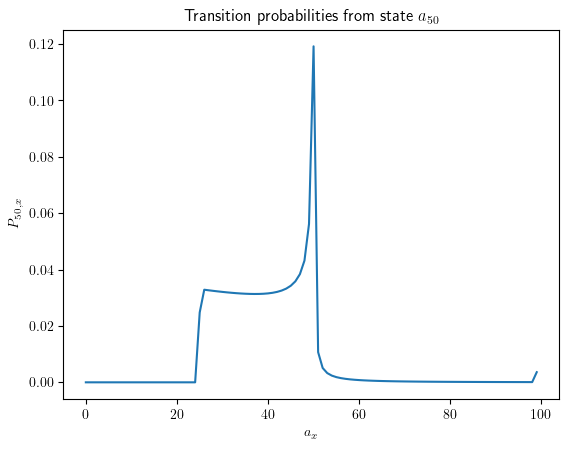

In [17]:
wired = CCA_CUBIC_MarkovChain(trans_err=0.5,beta=0.5,alpha=1,N=100,C =1000,RTT=0.5)
wired.avg_throughput()
print(f"Average throughput is {wired.x}")
plt.plot(np.arange(wired.N),wired.P[50,:])
plt.title(r"Transition probabilities from state $a_{50}$")
plt.ylabel(r"$P_{50,x}$")
plt.xlabel(r"$a_x$")

0.9999999999999999


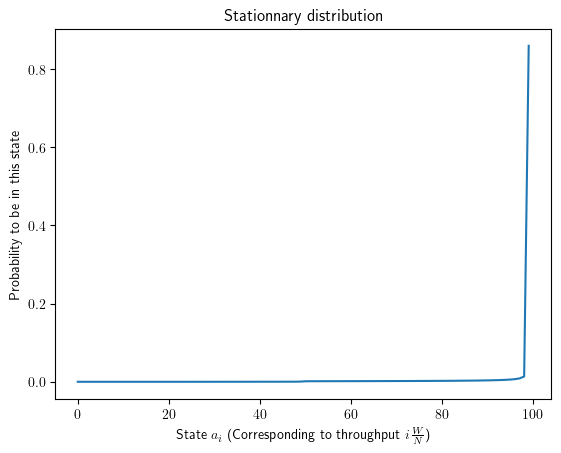

In [23]:
# Plot stationnary distribution
plt.plot(np.arange(wired.N),wired.pi)
plt.title(r"Stationnary distribution")
plt.xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
plt.ylabel(r'Probability to be in this state')
print(np.sum(wired.pi))

Text(0, 0.5, 'Normalised throughput')

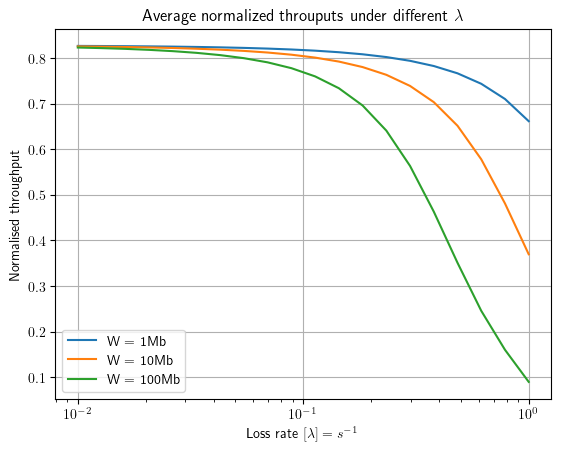

In [25]:
# Fig 7.

err_rates = np.logspace(-2,0,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([10,100,1000]):
    for i, l in enumerate(err_rates):
        wired = CCA_CUBIC_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100,C = C ,RTT=0.1)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$")
plt.xlabel(r"Loss rate $[\lambda] = s^{-1}$")
plt.ylabel(r'Normalised throughput')

Text(0, 0.5, 'Normalised throughput')

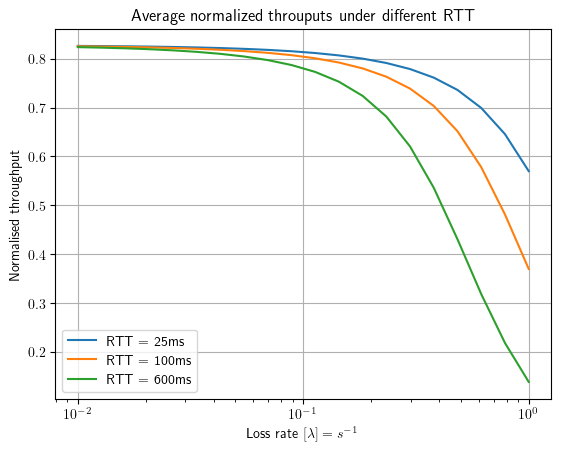

In [27]:
# Fig 7.

err_rates = np.logspace(-2,0,20)
throughputs = np.zeros([3,len(err_rates)])
for k,RTT in enumerate([0.025,0.1,0.6]):
    for i, l in enumerate(err_rates):
        wired = CCA_CUBIC_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100,C = 100,RTT=RTT)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(err_rates,throughputs[0,:], label = "RTT = 25ms")
plt.plot(err_rates,throughputs[1,:], label = "RTT = 100ms")
plt.plot(err_rates,throughputs[2,:], label = "RTT = 600ms")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Average normalized throuputs under different RTT")
plt.xlabel(r"Loss rate $[\lambda] = s^{-1}$")
plt.ylabel(r'Normalised throughput')

Text(0, 0.5, 'Normalised throughput')

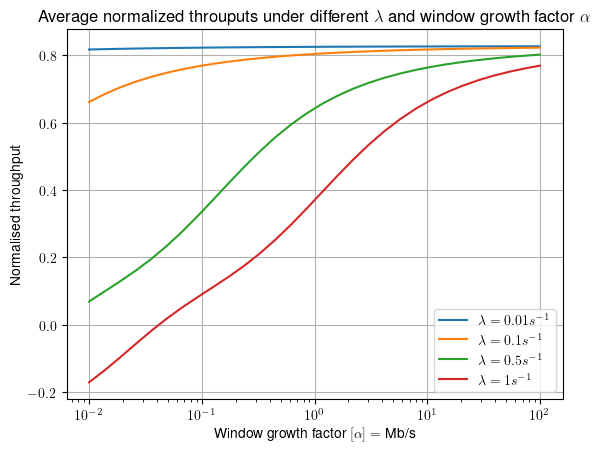

In [256]:
# Fig. 8 

alphas = np.logspace(-2,2,30)
throughputs = np.zeros([4,len(alphas)])
for k,lam in enumerate([0.01,0.1,0.5,1]):
    for i, alpha in enumerate(alphas):
        wired = CCA_CUBIC_MarkovChain(trans_err=lam,beta=0.5,alpha=alpha,N=100,W=100*0.1,RTT=100)
        throughputs[k,i] = wired.avg_throughput()

plt.plot(alphas,throughputs[0,:], label = r"$\lambda = 0.01 s^{-1}$")
plt.plot(alphas,throughputs[1,:], label = r"$\lambda = 0.1 s^{-1}$")
plt.plot(alphas,throughputs[2,:], label = r"$\lambda = 0.5 s^{-1}$")
plt.plot(alphas,throughputs[3,:], label = r"$\lambda = 1 s^{-1}$")
plt.semilogx()
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.title(r"Average normalized throuputs under different $\lambda$ and window growth factor $\alpha$")
plt.xlabel(r"Window growth factor $[\alpha] =$ Mb/s")
plt.ylabel(r'Normalised throughput')

In [15]:
fast = CCA_CUBIC_MarkovChain(trans_err=0.5,beta=0.5,alpha=1,N=100,C =100,RTT=0.025)
slow = CCA_CUBIC_MarkovChain(trans_err=0.5,beta=0.5,alpha=1,N=100,C =100,RTT=0.1)
print(fast.avg_throughput())
print(slow.avg_throughput())
print(fast.tau[99,99])
print(slow.tau[99,99])


0.7315465066033302
0.64252370573884
0.783017208342889
1.242962340232705


In [83]:
class CCA_Hybla_MarkovChain:
    def __init__(self, N=400, C = 100, trans_err = 0.01, alpha = 1, beta = 0.5, RTT = 600,RTT0 = 25, packet_err = 0.05, new = True):
        self.N = N # number of states
        self.C = C
        self.W = C * RTT # in Mbyte, W = C*RTT where C is the maximum bandwidth
        self.RTT = RTT # in ms 
        self.RTT0 = RTT0
        self.rho = max([RTT/RTT0,1])
        self.trans_err = trans_err # a.k.a. lambda 
        self.packet_err = packet_err # percentage chance that a packet is lost
        self.alpha = alpha # window growth rate
        self.beta = beta # window reduction ratio
        self.a = (np.linspace(1,N,N)-0.5)*self.W/N # Discretisation of the window-size
        self.pi = np.ones(N)/N # Stationnary Distribution
        self.P = None # Transition Probability Matrix
        self.S = None
        self.tau = None 
        self.x = 0 # Steady State average throughput
        self.new = new

    def D(self,x,y): # growth time in seconds
        return self.RTT0**2*(y-self.beta*x/self.RTT)
    
    def avg_w(self,t,x): # packets sent every RTT
        return self.beta*x+self.rho*t*self.alpha/(2*self.RTT0)

    def transition_proba_Hybla(self,i,j): # Probability to transition from i to j
        l = self.trans_err
        if j < self.beta*(i-0.5):
            return 0
        if j == self.N:
            sum = 0
            for jp in np.linspace(1,self.N-1,self.N-1):
                if jp >= self.beta*(i-0.5):
                    sum += self.transition_proba_Hybla(i,jp)
            return 1-sum
        return np.exp(-l* np.maximum(self.D(self.a[i-1],(j-1)*self.W/self.N),0)) - np.exp(-l* self.D(self.a[i-1],j*self.W/self.N))
    
    def transition_proba_Hybla_new(self,i,j):
        if j < self.beta*(i-0.5):
            return 0
        if j == self.N:
            sum = 0
            for jp in np.linspace(1,self.N-1,self.N-1):
                if jp >= self.beta*(i-0.5):
                    sum += self.transition_proba_Hybla_new(i,jp)
            return 1-sum
        t_min = np.maximum(self.D(self.a[i-1],(j-1)*self.W/self.N),0)
        t_max = self.D(self.a[i-1],j*self.W/self.N)

        return np.exp(-t_min*self.RTT/(self.avg_w(t=t_min,x=self.a[i-1])*self.packet_err))-np.exp(-t_max*self.RTT/(self.avg_w(t=t_max,x=self.a[i-1])*self.packet_err))
    
    def compute_stationnary_distribution(self):
        # 1. Compute the transition probability Matrix P
        self.P = np.zeros([self.N,self.N])
        for i in range(self.N):
            for j in range(self.N):
                if j == self.N:
                    self.P[i,j] = np.sum(self.P[i,:-1])
                    continue
                if not self.new:
                    self.P[i,j] = self.transition_proba_Hybla(i+1,j+1)
                else:
                    self.P[i,j] = self.transition_proba_Hybla_new(i+1,j+1)

        # 2. Solve the system of equation (16)&(17) 
        # piP = pi <=> pi(P-I)=0 <=> (P-I)^T pi = 0 
        # so pi is a left eigenvector of P, with eigenvalue 1
        # Furthermore, pis L1 norm needs to be equal to 1 
        w,v = np.linalg.eig(np.transpose(self.P)) # Compute eigenvalues/eigenvectors
        self.pi = np.real(v[:,0]/v[:,0].sum()) # Scale such that the values sum to 1
        return 
    
    def compute_tau_and_S(self):
        self.tau = np.zeros([self.N,self.N])
        self.S = np.zeros([self.N,self.N])
        for i in range(self.N):
            for j in range(self.N):
                self.tau[i,j] = np.maximum(self.D(self.a[i],(j-0.5)*self.W/self.N),0) # average time duration for state transistion from state i to j
                self.S[i,j] = (self.a[i]*self.tau[i,j]*self.beta + self.rho*self.tau[i,j]**2/(2*self.RTT0))/self.RTT
        return
    
    def avg_throughput(self):
        if self.P == None:
            self.compute_stationnary_distribution()
        self.compute_tau_and_S()
        numerator = np.dot(self.pi,np.dot(self.P,np.transpose(self.S)).diagonal())
        denominator = np.dot(self.pi,np.dot(self.P,np.transpose(self.tau)).diagonal())
        self.x = 1/self.C*numerator/denominator
        return self.x

In [84]:
wireless = CCA_Hybla_MarkovChain(trans_err=0.1,beta=0.5,alpha=1,N=100,C = 1000, RTT = 0.5, RTT0=0.025)
print(wireless.avg_throughput())
wired = CCA_CUBIC_MarkovChain(trans_err=0.1,beta=0.5,alpha=1,N=100,C =1000,RTT=0.5)
print(wired.avg_throughput())

0.4085971799296744
0.7081852900931364


Average throughput is 0.44660443690398643


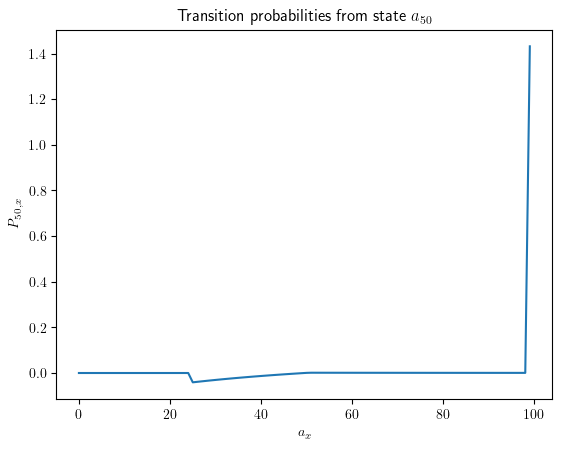

In [87]:
wireless = CCA_Hybla_MarkovChain(trans_err=10000,packet_err=0.01,beta=0.5,alpha=1,N=100,C = 10, RTT = 0.5, RTT0=0.025, new=True)
wireless.avg_throughput()
print(f"Average throughput is {wireless.x}")
plt.plot(np.arange(wireless.N),wireless.P[50,:])
plt.title(r"Transition probabilities from state $a_{50}$")
plt.ylabel(r"$P_{50,x}$")
plt.xlabel(r"$a_x$")
plt.show()

0.9999999999999997


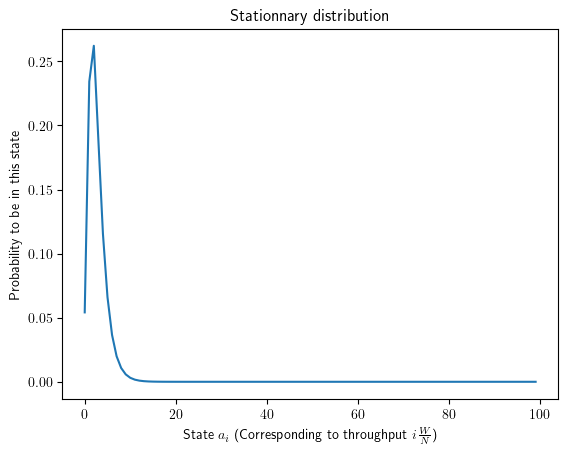

In [70]:
plt.plot(np.arange(wireless.N),wireless.pi)
plt.title(r"Stationnary distribution")
plt.xlabel(r"State $a_i$ (Corresponding to throughput $i\frac{W}{N}$)")
plt.ylabel(r'Probability to be in this state')
print(np.sum(wireless.pi))

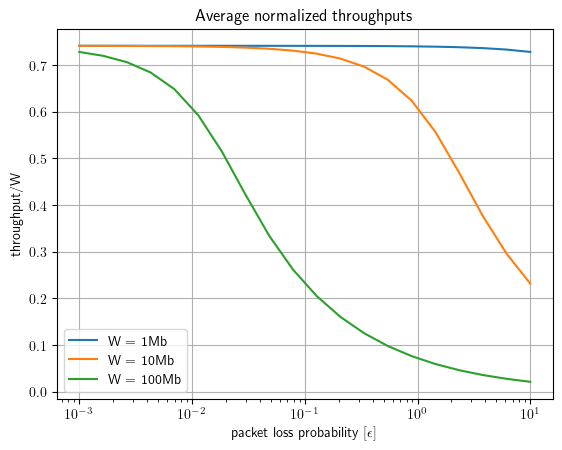

In [51]:
err_rates = np.logspace(-3,1,20)
throughputs = np.zeros([3,len(err_rates)])
for k,C in enumerate([10,100,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_Hybla_MarkovChain(packet_err=l,beta=0.5,alpha=1,N=100,C = C,RTT=0.5, RTT0=0.025)
        throughputs[k,i] = wireless.avg_throughput()



plt.plot(err_rates,throughputs[0,:], label = "W = 1Mb")
plt.plot(err_rates,throughputs[1,:], label = "W = 10Mb")
plt.plot(err_rates,throughputs[2,:], label = "W = 100Mb")
plt.semilogx()
plt.legend()
plt.grid()
plt.title(r"Average normalized throughputs")
plt.xlabel(r"packet loss probability $[\epsilon]$")
plt.ylabel(r'throughput/W')
plt.show()

In [34]:
err_rates = np.logspace(-2,0,20)
throughputs_hybla_bandwidth = np.zeros([3,len(err_rates)])
throughputs_cubic_bandwidth = np.zeros([3,len(err_rates)])
throughputs_hybla_rtt = np.zeros([3,len(err_rates)])
throughputs_cubic_rtt = np.zeros([3,len(err_rates)])

for k,C in enumerate([10,100,1000]):
    for i, l in enumerate(err_rates):
        wireless = CCA_Hybla_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100, C = C, RTT=0.1, RTT0=0.025)
        throughputs_hybla_bandwidth[k,i] = wireless.avg_throughput()
        wired = CCA_CUBIC_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100,C = C, RTT = 0.1)
        throughputs_cubic_bandwidth[k,i] = wired.avg_throughput()

for k,R in enumerate([0.025,0.1,0.6]):
    for i,l in enumerate(err_rates):
        wireless = CCA_Hybla_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100, C = 100, RTT=R, RTT0=0.025)
        throughputs_hybla_rtt[k,i] = wireless.avg_throughput()
        wired = CCA_CUBIC_MarkovChain(trans_err=l,beta=0.5,alpha=1,N=100,C = 100, RTT = R)
        throughputs_cubic_rtt[k,i] = wired.avg_throughput()

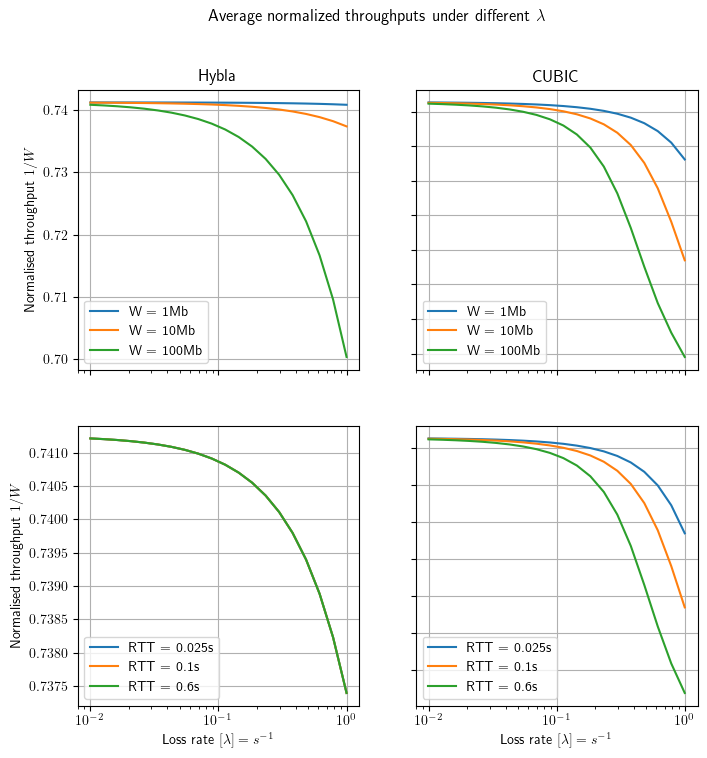

In [40]:
fig, axs = plt.subplots(2, 2)
fig.suptitle("Average normalized throughputs under different $\lambda$")
fig.set_figheight(8)
fig.set_figwidth(8)

axs[0, 0].plot(err_rates, throughputs_hybla_bandwidth[0,:],label = "W = 1Mb")
axs[0,0].plot(err_rates,throughputs_hybla_bandwidth[1,:], label = "W = 10Mb")
axs[0,0].plot(err_rates,throughputs_hybla_bandwidth[2,:], label = "W = 100Mb")
axs[0,0].semilogx()
axs[0,0].legend()
axs[0,0].grid()
axs[0,0].set_title(r"Hybla")

axs[0,1].plot(err_rates, throughputs_cubic_bandwidth[0,:],label = "W = 1Mb")
axs[0,1].plot(err_rates,throughputs_cubic_bandwidth[1,:], label = "W = 10Mb")
axs[0,1].plot(err_rates,throughputs_cubic_bandwidth[2,:], label = "W = 100Mb")
axs[0,1].semilogx()
axs[0,1].legend()
axs[0,1].grid()
axs[0,1].set_title(r"CUBIC")

axs[1,0].plot(err_rates, throughputs_hybla_rtt[0,:],label = "RTT = 0.025s")
axs[1,0].plot(err_rates,throughputs_hybla_rtt[1,:], label = "RTT = 0.1s")
axs[1,0].plot(err_rates,throughputs_hybla_rtt[2,:], label = "RTT = 0.6s")
axs[1,0].semilogx()
axs[1,0].legend()
axs[1,0].grid()

axs[1,1].plot(err_rates, throughputs_cubic_rtt[0,:],label = "RTT = 0.025s")
axs[1,1].plot(err_rates,throughputs_cubic_rtt[1,:], label = "RTT = 0.1s")
axs[1,1].plot(err_rates,throughputs_cubic_rtt[2,:], label = "RTT = 0.6s")
axs[1,1].semilogx()
axs[1,1].legend()
axs[1,1].grid()

for ax in axs.flat:
    ax.set(xlabel=r"Loss rate $[\lambda] = s^{-1}$", ylabel=r'Normalised throughput $1/W$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()